In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
from methods import IBU, NPU, MADE

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfb = tfp.bijectors

2023-02-20 08:53:03.402152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 08:53:03.498716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 08:53:03.498734: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 08:53:04.897320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Generate data for W0 training (as well as theta)

bins = np.linspace(-5,5,11)
nbins = len(bins)-1

Ndata = 100000
Nsim = 10000000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0
sigma_data = 1.2
beta_data = 0
epsilon_data = 1

p = np.array([1./nbins for i in range(1, nbins+1)])

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R = []
for i in range(1,nbins+1):
    T_sim_i = T_sim[np.digitize(T_sim, bins)==i]
    R_sim_i = np.random.normal(T_sim_i+beta_sim,epsilon_sim)
    ms = np.array([(np.digitize(R_sim_i, bins)==i).sum()/len(T_sim_i) for i in range(1, nbins+1)])
    ms /= ms.sum() # should we normalize the total probablitiy to 1?
    R.append(ms)
R = np.transpose(np.array(R))

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
R_data = np.random.normal(T_data+beta_data,epsilon_data)
t = np.array([(np.digitize(T_data, bins)==i).sum() for i in range(1, nbins+1)])
m = np.array([(np.digitize(R_data, bins)==i).sum() for i in range(1, nbins+1)])

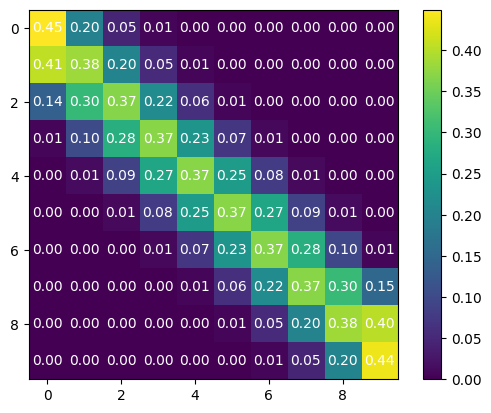

In [3]:
plt.imshow(R)
plt.colorbar()

for i in range(len(R)):
    for j in range(len(R)):
        text = plt.text(j, i, f"{R[i, j]:.2f}", ha="center", va="center", color="w")
        
plt.show()

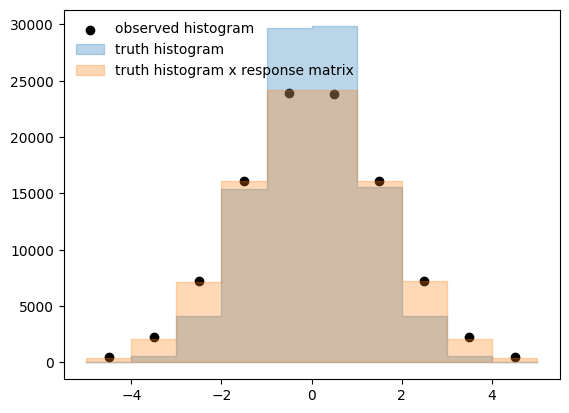

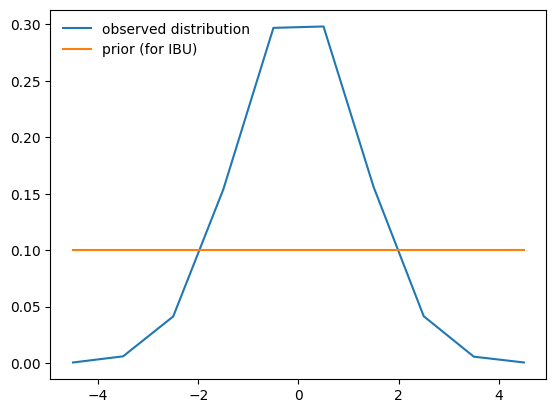

In [4]:
plt.scatter(0.5*(bins[1:]+bins[:-1]), m, color='black', label='observed histogram')
plt.fill_between(bins, np.insert(t, len(t), np.array(t[-1])), step='post', alpha=0.3, color='tab:blue', label='truth histogram')
plt.fill_between(bins, np.insert(np.matmul(R, t), len(np.matmul(R, t)), np.array(np.matmul(R, t)[-1])), step='post', alpha=0.3, color='tab:orange', label='truth histogram x response matrix')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

plt.plot(0.5*(bins[1:]+bins[:-1]), t/t.sum(), label='observed distribution')
plt.plot(0.5*(bins[1:]+bins[:-1]), p, label='prior (for IBU)')
plt.legend(frameon=False, loc="upper left")
plt.show()

In [5]:
def MLE(model,ymes,ndim):
    x = tf.Variable(ndim*[1.0/ndim])
    loss = lambda: -model.log_prob(x, bijector_kwargs={'conditional_input': ymes})
    losses = tfp.math.minimize(loss,
                               num_steps=10000,
                               #convergence_criterion=(
                               #     tfp.optimizers.convergence_criteria.LossNotDecreasing(atol=0.001)),
                               trainable_variables=[x],
                               optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return x

def MADE(data_shape, cond_shape):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2,
                                     hidden_units=[50,50,50], #To be changed when using bigger histograms
                                     event_shape=data_shape,
                                     activation='swish',
                                     conditional=True,
                                     conditional_event_shape=cond_shape,
                                    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data_shape]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data_shape,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond_shape,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_,c_], log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss=lambda _, log_prob: -log_prob)
    return model, distribution

def NPU(ymes,Rin,N):
    #Inputs: 
    # ymes: Measured data provided in a histogram with M bins (M,)
    # Rin: Detector resolution matrix. First coordinate is the measured value and second coordinate is the truth level. (M,M)
    # N: Total number of observations
    #Returns samples from p(true|measured).  Would normally want the mode over true, which is equivalent to the MLE given p(true) is uniform.

    M = 10000000 # a big number - should make bigger later
    nsample = 1000
#     ts = np.random.dirichlet(np.ones(len(ymes)),size=M)*N
    ts = np.random.uniform(0,1,(M,len(ymes))) #M values with B bins
    ts=ts/np.sum(ts,-1,keepdims=True)*N

    ms = []
    for j in range(len(ts)):
        if j % 100000 == 0: print(f"{j}/{len(ts)}")
        m_hold = [np.random.poisson(ts[j][i]) for i in range(len(ts[j]))] #stat fluctuations
        m_holds = np.random.multinomial(m_hold[0],Rin[:,0])
        for i in range(1, len(ts[j])):
            m_holds += np.random.multinomial(m_hold[i],Rin[:,i])
        ms += [m_holds]
        pass
    ts = np.array(ts)
    ms = np.array(ms)

    n = len(ts)
    x = ms #conditional feature
    y = ts #learn p(y|x)
    nx = N
    ny = N

    #Normalize the total number of events to make the NF easier to train
    x = x/float(nx)
    y = y/float(ny)

    model,dist = MADE(y.shape[1],x.shape[1])
    # Fit.
    batch_size = 10000
    myhistory = model.fit([y,x],
                          y=np.zeros((len(x),0), dtype=np.float32), #dummy labels
                          batch_size=batch_size,
                          epochs=3000,
                          verbose = 1)

    plt.plot(myhistory.history['loss'][10:-1])
    plt.xlabel("epochs")
    plt.ylabel("loss")

    #mle = MLE(dist,ymes/float(nx),y.shape[-1])
    #print(mle)
    mle = MLE(dist,ymes/float(nx),y.shape[-1]).numpy()
    output = dist.sample(nsample, bijector_kwargs={'conditional_input': np.tile(ymes/float(nx),nsample).reshape([nsample,len(ymes)])}).numpy()
    return output*ny,mle*ny

99865
0/10000000
100000/10000000
200000/10000000
300000/10000000
400000/10000000
500000/10000000
600000/10000000
700000/10000000
800000/10000000
900000/10000000
1000000/10000000
1100000/10000000
1200000/10000000
1300000/10000000
1400000/10000000
1500000/10000000
1600000/10000000
1700000/10000000
1800000/10000000
1900000/10000000
2000000/10000000
2100000/10000000
2200000/10000000
2300000/10000000
2400000/10000000
2500000/10000000
2600000/10000000
2700000/10000000
2800000/10000000
2900000/10000000
3000000/10000000
3100000/10000000
3200000/10000000
3300000/10000000
3400000/10000000
3500000/10000000
3600000/10000000
3700000/10000000
3800000/10000000
3900000/10000000
4000000/10000000
4100000/10000000
4200000/10000000
4300000/10000000
4400000/10000000
4500000/10000000
4600000/10000000
4700000/10000000
4800000/10000000
4900000/10000000
5000000/10000000
5100000/10000000
5200000/10000000
5300000/10000000
5400000/10000000
5500000/10000000
5600000/10000000
5700000/10000000
5800000/10000000
590000

2023-02-20 09:17:39.381333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1000/1000 [==============================] - 13s 11ms/step - loss: 0.1400
Epoch 2/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -12.6829
Epoch 3/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -16.2525
Epoch 4/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -17.3288
Epoch 5/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -18.2213
Epoch 6/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -19.1360
Epoch 7/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -20.2022
Epoch 8/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -21.4595
Epoch 9/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -22.1263


1000/1000 [==============================] - 12s 12ms/step - loss: -34.6447
Epoch 87/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.6817
Epoch 88/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.7380
Epoch 89/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.7834
Epoch 90/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.8219
Epoch 91/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.8601
Epoch 92/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.9056
Epoch 93/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.9465
Epoch 94/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -34.9853
Epoch 95/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -35.0237
Epoch 96/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -35.0512
Epoch 97/3000
1000/1000 

1000/1000 [==============================] - 12s 12ms/step - loss: -36.8455
Epoch 177/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.8574
Epoch 178/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.8744
Epoch 179/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.8871
Epoch 180/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9042
Epoch 181/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9102
Epoch 182/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9280
Epoch 183/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9525
Epoch 184/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9603
Epoch 185/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -36.9785
Epoch 186/3000
1000/1000 [==============================] - 12s 12ms/step - loss: -37.0079
Epoch 187/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -38.0948
Epoch 267/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1804
Epoch 268/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1119
Epoch 269/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1567
Epoch 270/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1693
Epoch 271/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1884
Epoch 272/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.1752
Epoch 273/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.2471
Epoch 274/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.2330
Epoch 275/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.2380
Epoch 276/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -38.2439
Epoch 277/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -39.1186
Epoch 357/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1518
Epoch 358/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1443
Epoch 359/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1383
Epoch 360/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1748
Epoch 361/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1780
Epoch 362/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1447
Epoch 363/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1531
Epoch 364/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.2237
Epoch 365/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.1712
Epoch 366/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.2471
Epoch 367/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -39.6873
Epoch 447/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7849
Epoch 448/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.6456
Epoch 449/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7113
Epoch 450/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7336
Epoch 451/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7464
Epoch 452/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7803
Epoch 453/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7038
Epoch 454/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7605
Epoch 455/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7711
Epoch 456/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.7165
Epoch 457/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.0000
Epoch 537/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0226
Epoch 538/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.8485
Epoch 539/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9763
Epoch 540/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9969
Epoch 541/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.8231
Epoch 542/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0852
Epoch 543/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9673
Epoch 544/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9557
Epoch 545/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9508
Epoch 546/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.8941
Epoch 547/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.0734
Epoch 627/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0487
Epoch 628/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0409
Epoch 629/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0685
Epoch 630/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1158
Epoch 631/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0323
Epoch 632/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1761
Epoch 633/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -39.9555
Epoch 634/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1970
Epoch 635/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0559
Epoch 636/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1109
Epoch 637/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.0654
Epoch 717/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2621
Epoch 718/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1299
Epoch 719/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2115
Epoch 720/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0978
Epoch 721/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2424
Epoch 722/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0687
Epoch 723/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2038
Epoch 724/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2091
Epoch 725/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1620
Epoch 726/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.0946
Epoch 727/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.3040
Epoch 807/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1034
Epoch 808/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2329
Epoch 809/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2881
Epoch 810/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1903
Epoch 811/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2532
Epoch 812/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2908
Epoch 813/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1580
Epoch 814/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1750
Epoch 815/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3482
Epoch 816/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.1585
Epoch 817/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.2789
Epoch 897/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3526
Epoch 898/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2322
Epoch 899/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3514
Epoch 900/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2466
Epoch 901/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3224
Epoch 902/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2351
Epoch 903/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2950
Epoch 904/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3282
Epoch 905/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3139
Epoch 906/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2910
Epoch 907/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.3274
Epoch 987/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3290
Epoch 988/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4011
Epoch 989/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3143
Epoch 990/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3424
Epoch 991/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3402
Epoch 992/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3619
Epoch 993/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3963
Epoch 994/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3008
Epoch 995/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4291
Epoch 996/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3305
Epoch 997/3000

1000/1000 [==============================] - 11s 11ms/step - loss: -40.3377
Epoch 1076/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4165
Epoch 1077/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4054
Epoch 1078/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3546
Epoch 1079/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4168
Epoch 1080/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3763
Epoch 1081/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3629
Epoch 1082/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.2928
Epoch 1083/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4560
Epoch 1084/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3935
Epoch 1085/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3837
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.3692
Epoch 1165/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5000
Epoch 1166/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4220
Epoch 1167/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4431
Epoch 1168/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4396
Epoch 1169/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4167
Epoch 1170/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4812
Epoch 1171/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4314
Epoch 1172/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4165
Epoch 1173/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4222
Epoch 1174/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4183
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.4810
Epoch 1254/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5383
Epoch 1255/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3644
Epoch 1256/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5009
Epoch 1257/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5440
Epoch 1258/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4191
Epoch 1259/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4835
Epoch 1260/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.3829
Epoch 1261/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5108
Epoch 1262/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5677
Epoch 1263/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4549
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.5821
Epoch 1343/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4584
Epoch 1344/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6017
Epoch 1345/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4767
Epoch 1346/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5073
Epoch 1347/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5925
Epoch 1348/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4817
Epoch 1349/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4784
Epoch 1350/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4987
Epoch 1351/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5386
Epoch 1352/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5943
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.5323
Epoch 1432/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5395
Epoch 1433/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4719
Epoch 1434/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6303
Epoch 1435/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6345
Epoch 1436/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4842
Epoch 1437/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5527
Epoch 1438/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5354
Epoch 1439/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6167
Epoch 1440/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4897
Epoch 1441/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5882
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.5574
Epoch 1521/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6151
Epoch 1522/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6131
Epoch 1523/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6267
Epoch 1524/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6065
Epoch 1525/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5098
Epoch 1526/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6837
Epoch 1527/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5157
Epoch 1528/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6542
Epoch 1529/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5721
Epoch 1530/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4675
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.6260
Epoch 1610/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6055
Epoch 1611/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5736
Epoch 1612/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7089
Epoch 1613/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5921
Epoch 1614/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7090
Epoch 1615/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6240
Epoch 1616/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5143
Epoch 1617/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7425
Epoch 1618/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.4916
Epoch 1619/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6835
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.7466
Epoch 1699/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6467
Epoch 1700/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6747
Epoch 1701/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6262
Epoch 1702/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6703
Epoch 1703/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6448
Epoch 1704/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6272
Epoch 1705/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7004
Epoch 1706/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7403
Epoch 1707/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.5964
Epoch 1708/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6988
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.7865
Epoch 1788/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6909
Epoch 1789/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6796
Epoch 1790/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6207
Epoch 1791/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7112
Epoch 1792/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8027
Epoch 1793/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6929
Epoch 1794/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6094
Epoch 1795/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7367
Epoch 1796/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6715
Epoch 1797/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7596
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.6597
Epoch 1877/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7258
Epoch 1878/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7320
Epoch 1879/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7091
Epoch 1880/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7701
Epoch 1881/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7144
Epoch 1882/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7696
Epoch 1883/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6742
Epoch 1884/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7064
Epoch 1885/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7916
Epoch 1886/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7318
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.7562
Epoch 1966/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7664
Epoch 1967/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7224
Epoch 1968/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7693
Epoch 1969/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7680
Epoch 1970/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7431
Epoch 1971/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7511
Epoch 1972/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7476
Epoch 1973/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8640
Epoch 1974/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.6742
Epoch 1975/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7027
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.8359
Epoch 2055/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7066
Epoch 2056/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8840
Epoch 2057/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7595
Epoch 2058/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7959
Epoch 2059/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7509
Epoch 2060/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8443
Epoch 2061/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7388
Epoch 2062/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8278
Epoch 2063/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7726
Epoch 2064/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7467
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.8287
Epoch 2144/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7977
Epoch 2145/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8451
Epoch 2146/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8155
Epoch 2147/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7805
Epoch 2148/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8123
Epoch 2149/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7854
Epoch 2150/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8520
Epoch 2151/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7693
Epoch 2152/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7602
Epoch 2153/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8654
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.8610
Epoch 2233/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8609
Epoch 2234/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8891
Epoch 2235/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8079
Epoch 2236/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8074
Epoch 2237/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8958
Epoch 2238/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7172
Epoch 2239/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9367
Epoch 2240/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8452
Epoch 2241/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8041
Epoch 2242/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8689
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.9473
Epoch 2322/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8250
Epoch 2323/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8523
Epoch 2324/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8730
Epoch 2325/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8691
Epoch 2326/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8480
Epoch 2327/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9417
Epoch 2328/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8067
Epoch 2329/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9159
Epoch 2330/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8430
Epoch 2331/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9223
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.9313
Epoch 2411/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8980
Epoch 2412/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8836
Epoch 2413/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8223
Epoch 2414/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9398
Epoch 2415/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9376
Epoch 2416/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8084
Epoch 2417/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9763
Epoch 2418/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8999
Epoch 2419/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7902
Epoch 2420/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9641
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.8496
Epoch 2500/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8982
Epoch 2501/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8743
Epoch 2502/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9134
Epoch 2503/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9382
Epoch 2504/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8991
Epoch 2505/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9659
Epoch 2506/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9424
Epoch 2507/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9068
Epoch 2508/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8646
Epoch 2509/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9234
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.9967
Epoch 2589/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9446
Epoch 2590/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9129
Epoch 2591/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8435
Epoch 2592/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8909
Epoch 2593/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9424
Epoch 2594/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9680
Epoch 2595/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9788
Epoch 2596/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9647
Epoch 2597/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.7849
Epoch 2598/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0274
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.9877
Epoch 2678/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9259
Epoch 2679/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0298
Epoch 2680/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9293
Epoch 2681/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8900
Epoch 2682/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9883
Epoch 2683/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0552
Epoch 2684/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9824
Epoch 2685/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9565
Epoch 2686/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.8620
Epoch 2687/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9710
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -40.9490
Epoch 2767/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0402
Epoch 2768/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9625
Epoch 2769/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0695
Epoch 2770/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9989
Epoch 2771/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9356
Epoch 2772/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0212
Epoch 2773/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9939
Epoch 2774/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9604
Epoch 2775/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0390
Epoch 2776/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9741
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -41.0401
Epoch 2856/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9417
Epoch 2857/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0567
Epoch 2858/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9898
Epoch 2859/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0983
Epoch 2860/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0180
Epoch 2861/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9853
Epoch 2862/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0192
Epoch 2863/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9856
Epoch 2864/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0192
Epoch 2865/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0780
Epoc

1000/1000 [==============================] - 11s 11ms/step - loss: -41.0539
Epoch 2945/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9490
Epoch 2946/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.1458
Epoch 2947/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0065
Epoch 2948/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0838
Epoch 2949/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9799
Epoch 2950/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.1277
Epoch 2951/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0124
Epoch 2952/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0911
Epoch 2953/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -41.0629
Epoch 2954/3000
1000/1000 [==============================] - 11s 11ms/step - loss: -40.9774
Epoc

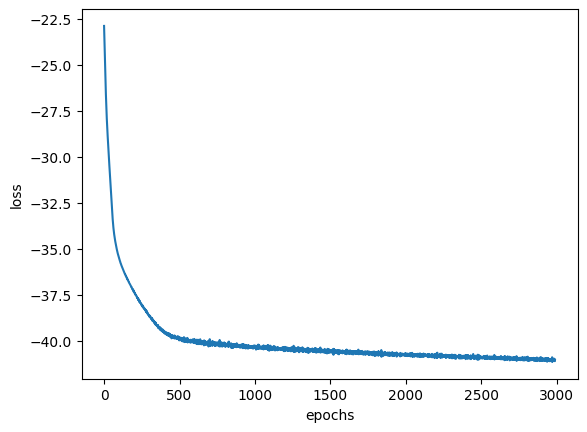

In [6]:
N = m.sum()
print(N)

npu,mle = NPU(m,R,N)

In [8]:
ibu = IBU(m,p,R,10)

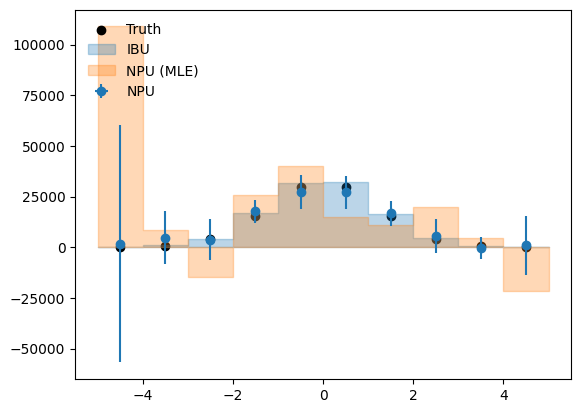

<Figure size 640x480 with 0 Axes>

In [8]:
# plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
# train stat = 10000
plt.errorbar(0.5*(bins[1:]+bins[:-1]), npu.mean(axis=0), xerr=0, yerr=npu.std(axis=0), label='NPU', marker='o', linestyle='None')
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='Truth')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

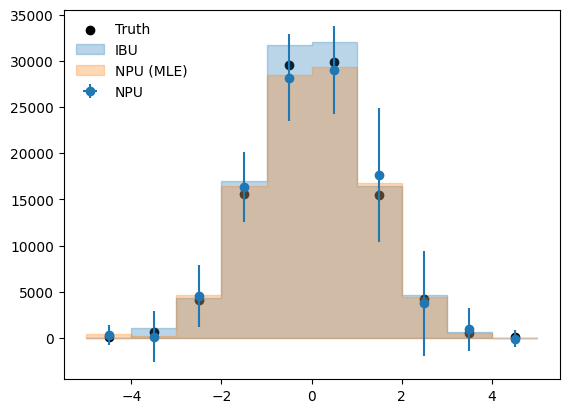

<Figure size 640x480 with 0 Axes>

In [11]:
# plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
# train stat = 100000
plt.errorbar(0.5*(bins[1:]+bins[:-1]), npu.mean(axis=0), xerr=0, yerr=npu.std(axis=0), label='NPU', marker='o', linestyle='None')
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='Truth')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

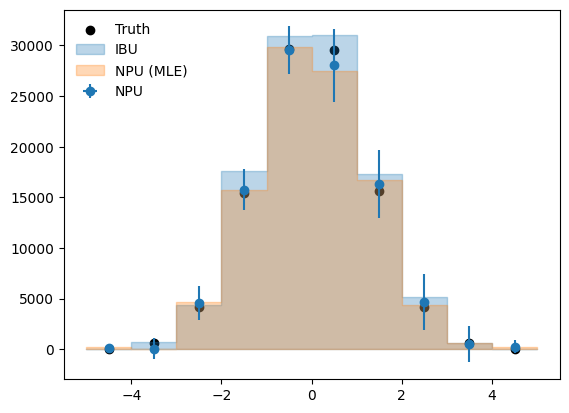

<Figure size 640x480 with 0 Axes>

In [27]:
# plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
# train stat = 1000000
plt.errorbar(0.5*(bins[1:]+bins[:-1]), npu.mean(axis=0), xerr=0, yerr=npu.std(axis=0), label='NPU', marker='o', linestyle='None')
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='Truth')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

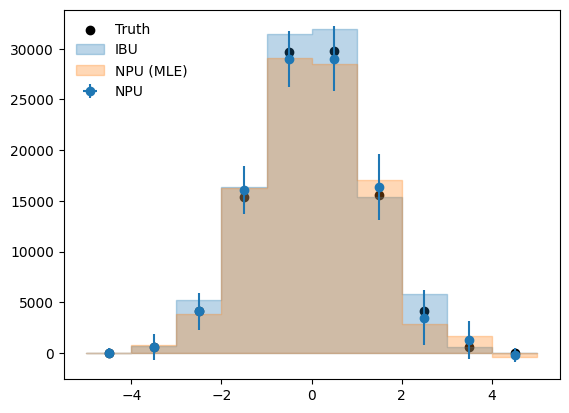

<Figure size 640x480 with 0 Axes>

In [9]:
# plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
# train stat = 10000000
plt.errorbar(0.5*(bins[1:]+bins[:-1]), npu.mean(axis=0), xerr=0, yerr=npu.std(axis=0), label='NPU', marker='o', linestyle='None')
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='Truth')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

In [10]:
!python -m pip install corner


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [11]:
np.savez_compressed("npu_gaussian_10000000.npz", **{"bins": bins, "npu": npu, "t": t, "ibu": ibu, "mle": mle})

In [12]:
aaa=np.load("npu_gaussian_10000000.npz")

In [13]:
list(aaa.keys())

['bins', 'npu', 't', 'ibu', 'mle']

In [18]:
import corner

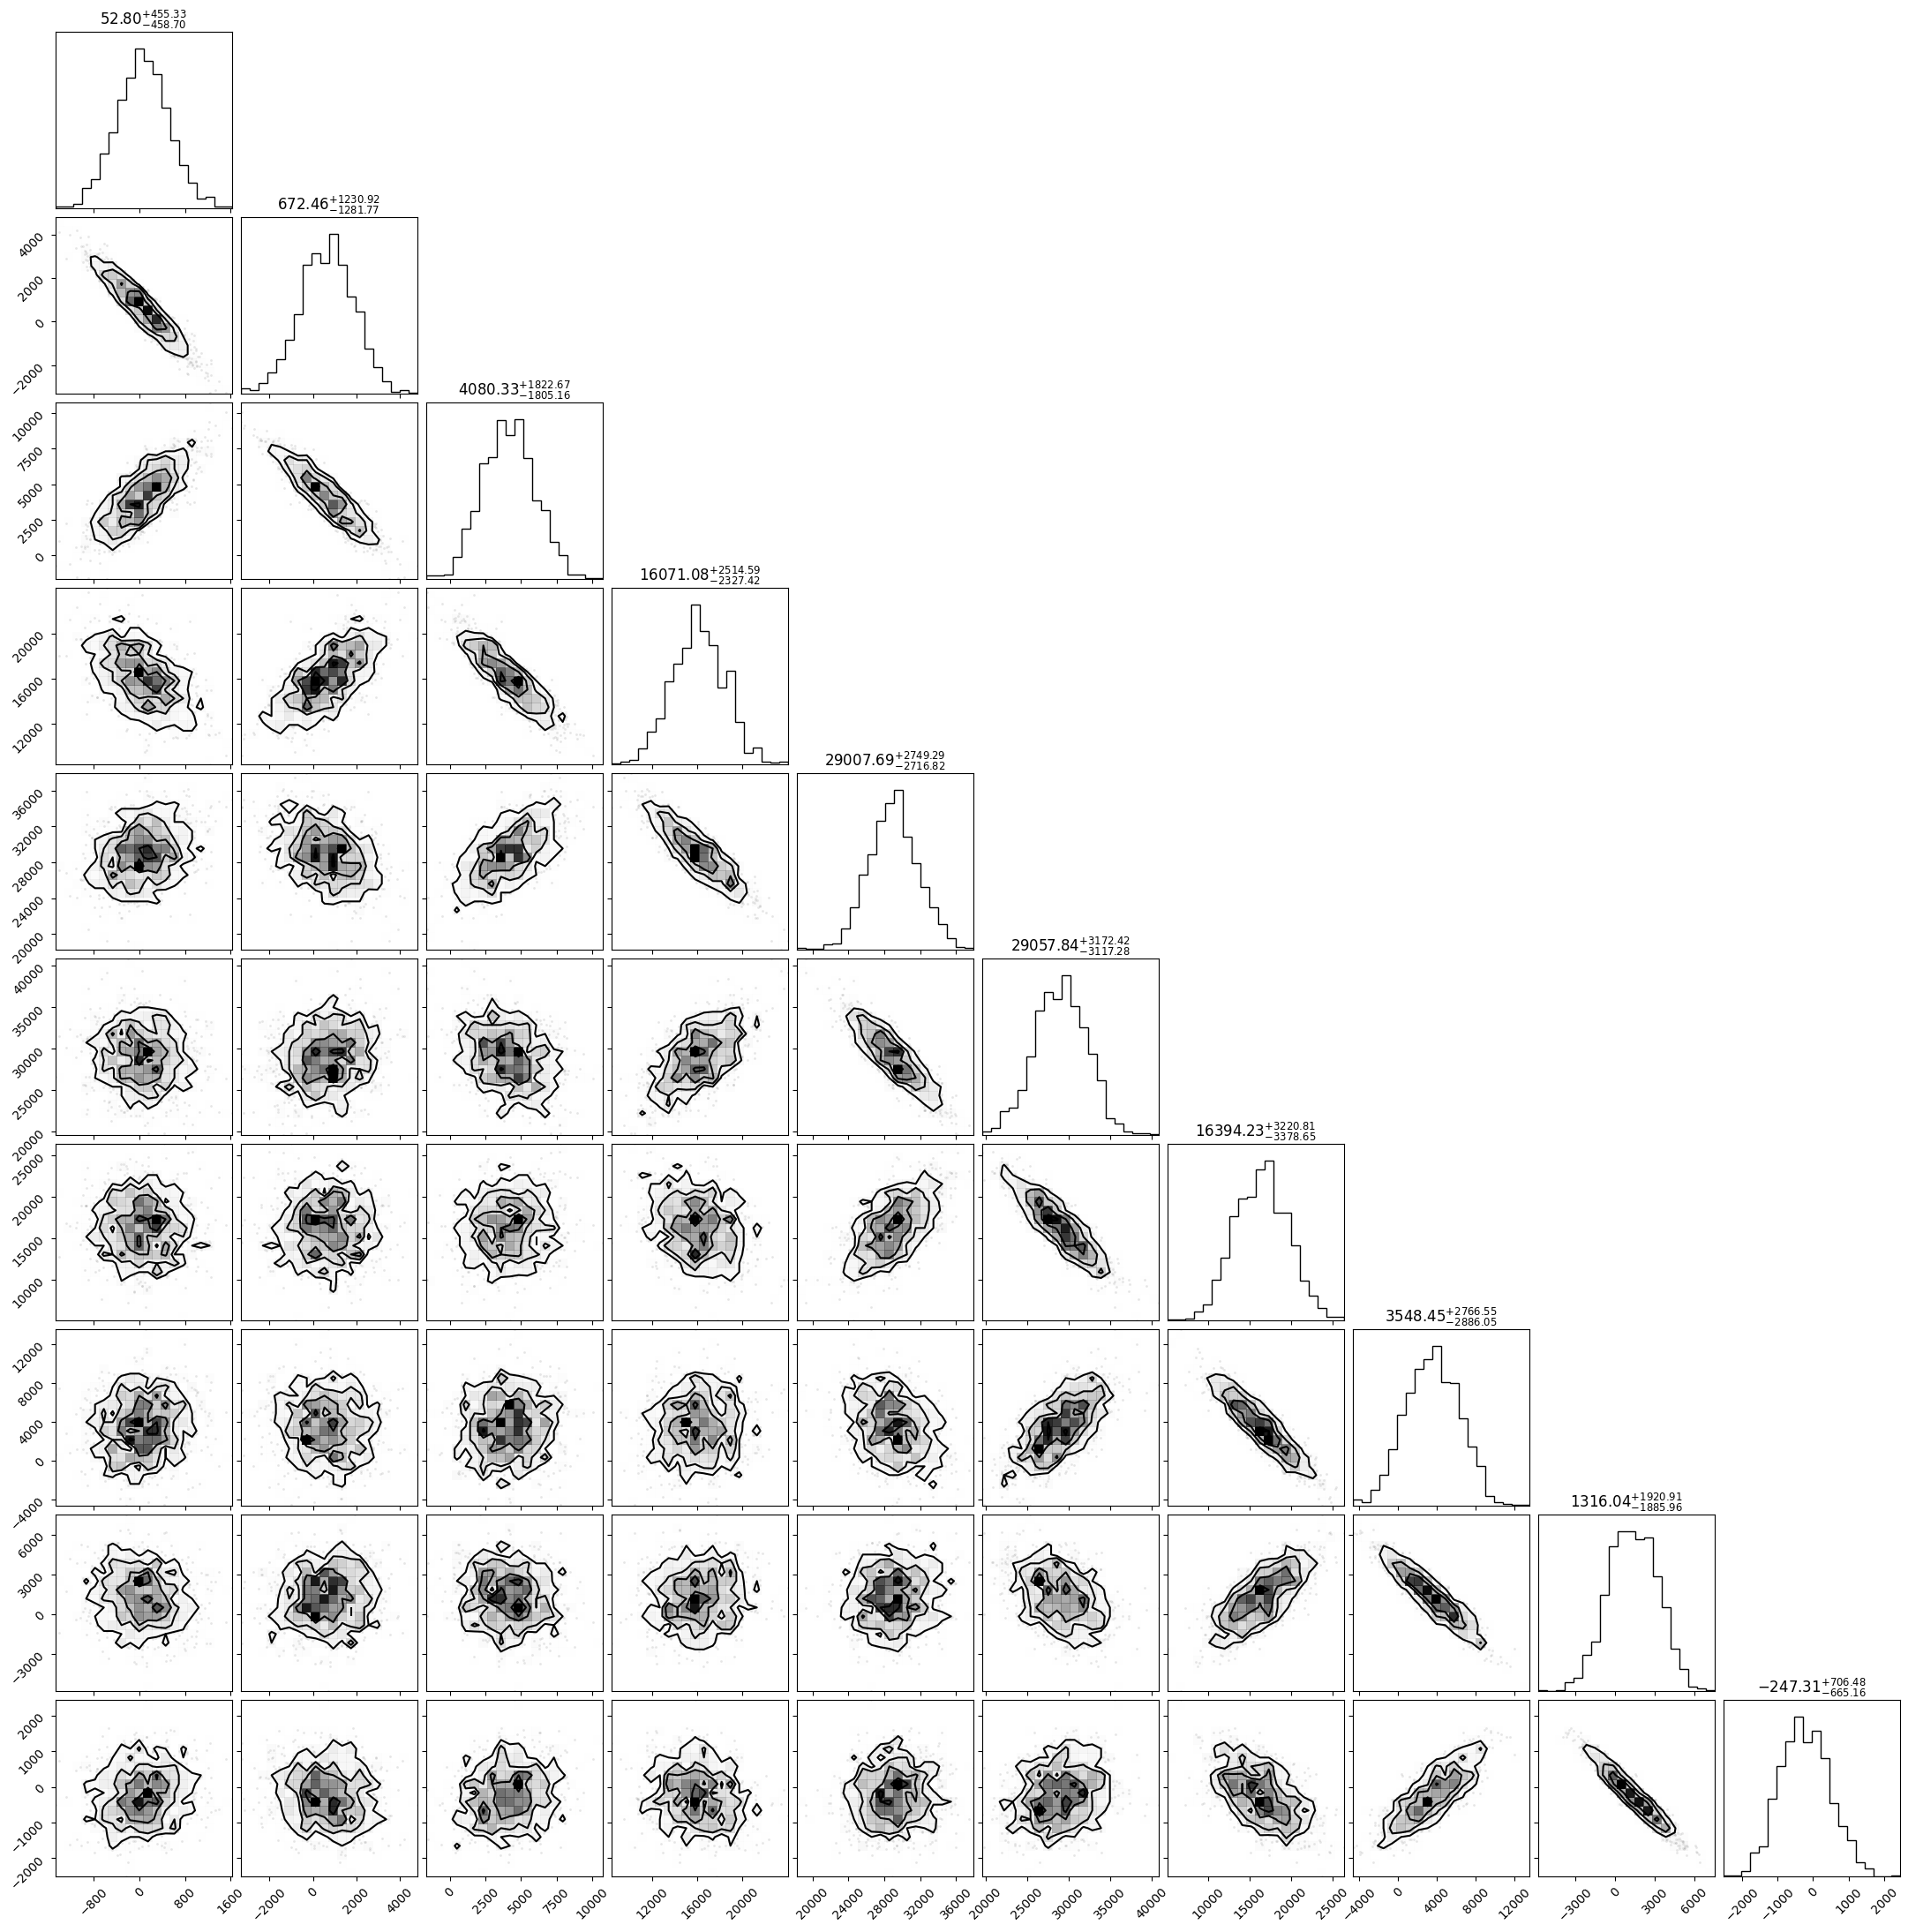

In [19]:
figure = corner.corner(
    npu,
#     labels=[
#         r"Bin Index",
#         r"Bin Index",
#         r"$\log \alpha$",
#         r"$\Gamma \, [\mathrm{parsec}]$",
#     ],
#     quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)